# Simple Evolutionary Strategy
An evolutionary strategy (ES) can be defined as follows.

Given a _fitness_ function that takes in a _member_, the algorithm produces a _population_ of candidates in the current _generation_.

These are then _evaluated_ for their fitness and subsequently, using that, the algorithm iterates to give the next generation.

In code:
```python
evaluate = lambda population: fitness(member) for member in population
def es(population):
    fitness = evaluate(population)
    new_population = f(population, fitness) # function unique to the algorithm
    return new_population

population = initial_population # Given some initial population
for _ in range(num_steps): population = es(population)

max_fitness_id = argmax(evaluate(population))
best_member = population[max_fitness_id]
```

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from functools import partial
from tqdm import tqdm_notebook as tqdm

from concurrent.futures import ProcessPoolExecutor

In [4]:
from utils.environment import add_energy, make_specs, run_env
from utils.model import get_params, set_params, get_action

## Define Useful Features

In [5]:
jtplot_style()

## Load Environment

In [6]:
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [8]:
add_energy(env)

# Create Model

In [9]:
get_model = lambda: nn.Linear(n_obs, n_act)

In [10]:
model = get_model()

# Create ES

In [11]:
class ES:
    def __init__(self, population_size):
        self._population_size = population_size
        self._history = []
        self._generation = 0
        
    def __call__(self, generations=1, num_workers=None):
        for _ in tqdm(range(generations)):
            self._population, reward = self._strategy(num_workers)
            self._generation += 1
            self._history.append((self._generation, reward))
            print(f'{reward:.2f}', end='\r')
            
    def _strategy(self):
        pass
    
    def solution(self):
        pass
    
    def plot_history(self):
        plot(*zip(*self._history))

In [19]:
class SimpleES(ES):
    def __init__(self, evaluator, population_size, mean, std=1):
        super().__init__(population_size)
        self._evaluator = evaluator
        self._mean = mean
        self._std = std
        self._population = [mean + torch.randn(len(mean)) * std 
                            for _ in range(population_size)]
        self._history.append((0, evaluator(mean)))
    
    def _strategy(self, num_workers):
        with ProcessPoolExecutor(num_workers) as executor: 
            fitness = list(executor.map(self._evaluator, self._population))
        
        max_fitness_id = np.argmax(fitness)
        self._mean = self._population[max_fitness_id]
        reward = fitness[max_fitness_id]
        
        new_population = [self._mean + torch.randn(len(self._mean)) * self._std 
                          for _ in range(self._population_size)]
        
        return new_population, reward
        
    def solution(self):
        return self._mean

In [13]:
def evaluator(params, gamma=0, episodes=1):
    model = get_model()
    set_params(model, params)
    rewards, energies = run_env(env, lambda x: get_action(model, x), episodes)
    return rewards - gamma * energies

In [20]:
solver = SimpleES(partial(evaluator, gamma=0.0, episodes=1), 5,
                  torch.zeros(len(get_params(model))))

In [21]:
solver(10)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

-96.00


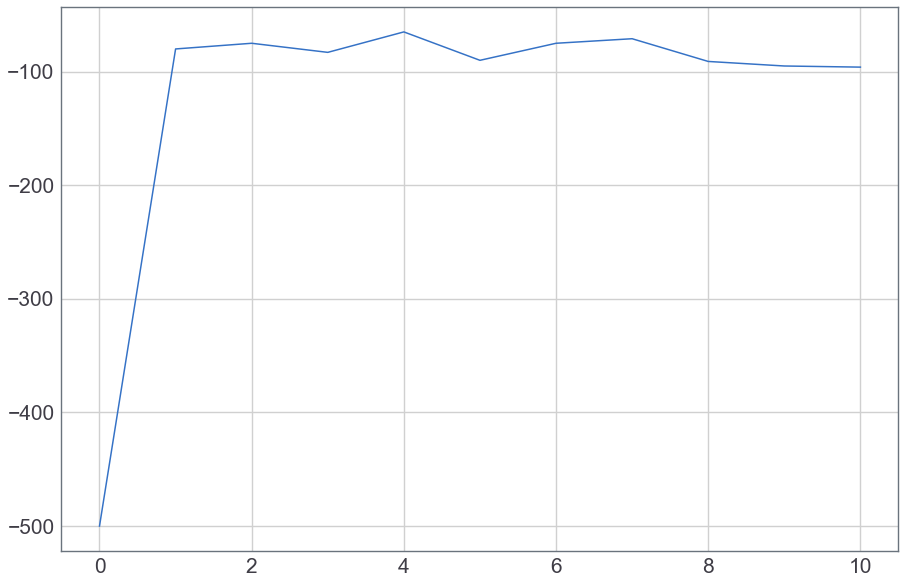

In [22]:
solver.plot_history()

In [23]:
set_params(model, solver.solution())

# Sample Model

In [24]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-536.0, 0)